# Maxpooling Layer

In this notebook, we add and visualize the output of a maxpooling layer in a CNN. 

A convolutional layer + activation function, followed by a pooling layer, and a linear layer (to create a desired output size) make up the basic layers of a CNN.

<img src='notebook_ims/CNN_all_layers.png' height=50% width=50% />

### Import the image


Bad key axes.color_cycle in file /Users/mohamedabdelbary/.matplotlib/matplotlibrc, line 240 ('axes.color_cycle    : 348ABD, A60628, 7A68A6, 467821,D55E00,  CC79A7, 56B4E9, 009E73, F0E442, 0072B2  # color cycle for plot lines')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.3/matplotlibrc.template
or from the matplotlib source distribution


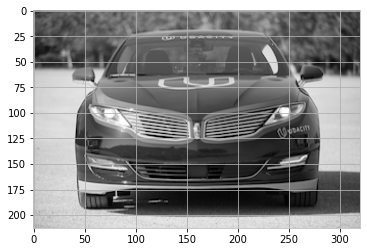

In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# TODO: Feel free to try out your own images here by changing img_path
# to a file path to another image on your computer!
img_path = 'data/udacity_sdc.png'

# load color image 
bgr_img = cv2.imread(img_path)
# convert to grayscale
gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)

# normalize, rescale entries to lie in [0,1]
gray_img = gray_img.astype("float32")/255

# plot image
plt.imshow(gray_img, cmap='gray')
plt.show()

### Define and visualize the filters

In [2]:
import numpy as np

## TODO: Feel free to modify the numbers here, to try out another filter!
filter_vals = np.array([[-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1]])

print('Filter shape: ', filter_vals.shape)


Filter shape:  (4, 4)


In [3]:
# Defining four different filters, 
# all of which are linear combinations of the `filter_vals` defined above

# define four filters
filter_1 = filter_vals
filter_2 = -filter_1
filter_3 = filter_1.T
filter_4 = -filter_3
filters = np.array([filter_1, filter_2, filter_3, filter_4])

# For an example, print out the values of filter 1
print('Filter 1: \n', filter_1)

Filter 1: 
 [[-1 -1  1  1]
 [-1 -1  1  1]
 [-1 -1  1  1]
 [-1 -1  1  1]]


### Define convolutional and pooling layers

You've seen how to define a convolutional layer, next is a:
* Pooling layer

In the next cell, we initialize a convolutional layer so that it contains all the created filters. Then add a maxpooling layer, [documented here](http://pytorch.org/docs/stable/_modules/torch/nn/modules/pooling.html), with a kernel size of (2x2) so you can see that the image resolution has been reduced after this step!

A maxpooling layer reduces the x-y size of an input and only keeps the most *active* pixel values. Below is an example of a 2x2 pooling kernel, with a stride of 2, applied to a small patch of grayscale pixel values; reducing the x-y size of the patch by a factor of 2. Only the maximum pixel values in 2x2 remain in the new, pooled output.

<img src='notebook_ims/maxpooling_ex.png' height=50% width=50% />

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
    
# define a neural network with a convolutional layer with four filters
# AND a pooling layer of size (2, 2)
class Net(nn.Module):
    
    def __init__(self, weight):
        super(Net, self).__init__()
        # initializes the weights of the convolutional layer to be the weights of the 4 defined filters
        k_height, k_width = weight.shape[2:]
        # assumes there are 4 grayscale filters
        self.conv = nn.Conv2d(1, 4, kernel_size=(k_height, k_width), bias=False)
        self.conv.weight = torch.nn.Parameter(weight)
        # define a pooling layer
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        # calculates the output of a convolutional layer
        # pre- and post-activation
        conv_x = self.conv(x)
        activated_x = F.relu(conv_x)
        
        # applies pooling layer
        pooled_x = self.pool(activated_x)
        
        # returns all layers
        return conv_x, activated_x, pooled_x
    
# instantiate the model and set the weights
weight = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
model = Net(weight)

# print out the layer in the network
print(model)

Net(
  (conv): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


### Visualize the output of each filter

First, we'll define a helper function, `viz_layer` that takes in a specific layer and number of filters (optional argument), and displays the output of that layer once an image has been passed through.

In [5]:
# helper function for visualizing the output of a given layer
# default number of filters is 4
def viz_layer(layer, n_filters= 4):
    fig = plt.figure(figsize=(20, 20))
    
    for i in range(n_filters):
        ax = fig.add_subplot(1, n_filters, i+1)
        # grab layer outputs
        ax.imshow(np.squeeze(layer[0,i].data.numpy()), cmap='gray')
        ax.set_title('Output %s' % str(i+1))

Let's look at the output of a convolutional layer after a ReLu activation function is applied.

#### ReLu activation

A ReLu function turns all negative pixel values in 0's (black). See the equation pictured below for input pixel values, `x`. 

<img src='notebook_ims/relu_ex.png' height=50% width=50% />

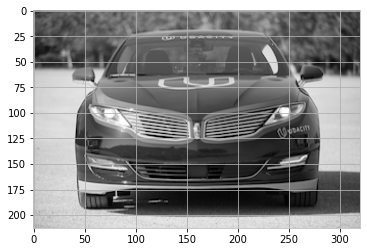

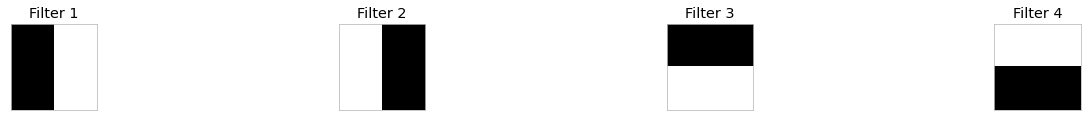

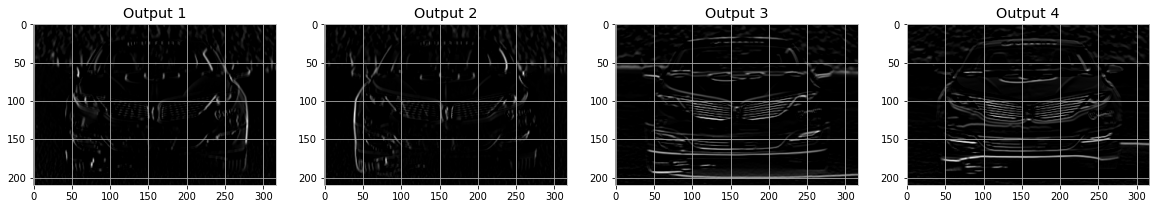

In [6]:
# plot original image
plt.imshow(gray_img, cmap='gray')

# visualize all filters
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0, right=1.5, bottom=0.8, top=1, hspace=0.05, wspace=0.05)
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))

    
# convert the image into an input Tensor
gray_img_tensor = torch.from_numpy(gray_img).unsqueeze(0).unsqueeze(1)

# get all the layers 
conv_layer, activated_layer, pooled_layer = model(gray_img_tensor)

# visualize the output of the activated conv layer
viz_layer(activated_layer)

### Visualize the output of the pooling layer

Then, take a look at the output of a pooling layer. The pooling layer takes as input the feature maps pictured above and reduces the dimensionality of those maps, by some pooling factor, by constructing a new, smaller image of only the maximum (brightest) values in a given kernel area.

Take a look at the values on the x, y axes to see how the image has changed size.



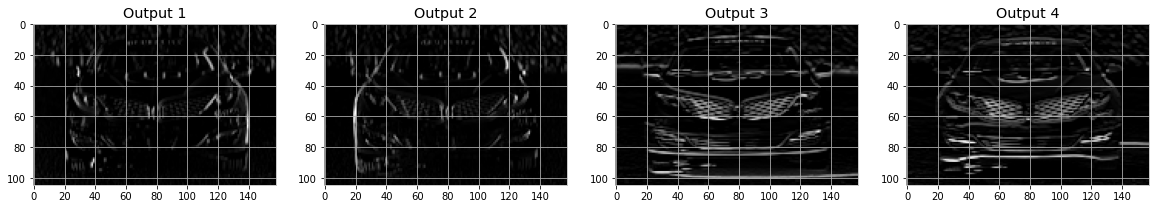

In [7]:
# visualize the output of the pooling layer
viz_layer(pooled_layer)